In [1]:
import copy
import os
import math
import re

import scipy
import numpy as np
import pandas as pd 

from scipy.spatial.transform import Rotation as Rot
import matplotlib.pyplot as plt
from multipledispatch import dispatch

# Class define

## Sensor File IO

In [2]:
sensornamedict = {'acc':'ACCELEROMETER',
                  'game_rv':'GAME_ROTATION_VECTOR',
                  'gps':'GPS',
                  'gps_2':'GPS',
                  'gravity':'GRAVITY',
                  'gyro':'GYROSCOPE',
                  'gyro_uncalib':'GYROSCOPE_UNCALIBRATED',
                  'linacc':'LINEAR_ACCELERATION',
                  'magnet':'MAGNETIC_FIELD',
                  'magnet_uncalib':'MAGNETIC_FIELD_UNCALIBRATED',
                  'pressure':'PRESSURE',
                  'ronin':'RONIN',
                  'rv':'ROTATION_VECTOR',
                  'step':'STEP',
                  'wifi':'WIFI'}
sensorcolumndict = {'acc':['Time','X','Y','Z'],
                    'game_rv':['Time','X','Y','Z','W'],
                    'gps':['Time','Latitude','Longitude'],
                    'gps_2':['Time','Latitude','Longitude','Sigma'],
                    'gravity':['Time','X','Y','Z'],
                    'gyro':['Time','X','Y','Z'],
                    'gyro_uncalib':['Time','X_uncalib','Y_uncalib','Z_uncalib','X_drift','Y_drift','Z_drift'],
                    'linacc':['Time','X','Y','Z'],
                    'magnet':['Time','X','Y','Z'],
                    'magnet_uncalib':['Time','X_uncalib','Y_uncalib','Z_uncalib','X_bias','Y_bias','Z_bias'],
                    'pressure':['Time','Pressure'],
                    'ronin':['Time','X','Y'],
                    'rv':['Time','X','Y','Z','W','Var_Unknown_placeholder'],
                    'step':['Time','Step'],
                    'wifi':['Time','Mac','RSSI','Var_Unknown_placeholder','SSID']}

def parse_comment(path:str) -> dict:
    # extract commented lines
    with open(path) as file:
        comments = ''
        for line in file:
            if line.startswith('#'):
                comments += line # saves comments as a single string
            else:
                break
    # struct info from comments to dict
    comments = re.split('[\t,\n]',comments) # split strings by sep and newline
    comments = [x.split(': ') for x  in comments if len(x.split(': ')) == 2] # split by ': ' and save to list only when there are two elements. e.g. A: B
    out_dict = {}
    for elem in comments:
        out_dict[elem[0]] = int(elem[1]) if elem[1].isnumeric() else elem[1] # cast the value as integer if value is numeric
    return out_dict

def align_time(time,currenttime,elapsedtime):
    '''
    Align timestamp to elapsed time (nanosec)
    time: array-like object with timestamp as elements
    currenttime: currentTimeMillis
    elapsedtime: elapsedRealtimeNanos
    '''
    bias = currenttime * int(1e6) - elapsedtime
    if len(time) != 0:
        # digit = math.ceil(math.log10(time[0]))
        # if digit == 15:
        #     time_type = 'elapsedRealtimeNanos'
        #     time_new = time
        # elif digit == 13:
        #     time_type = 'currentTimeMillis'
        #     time_new = time*int(1e6) - bias
        # else:
        #     time_type = 'elapsedRealtimeNanos'
        #     time_new = time*int(1e3)
            
        head_index = 3
        currenttime_head = str(currenttime)[:head_index]
        elapsedtime_head = str(elapsedtime)[:head_index]
        time_head = str(time[0])[:head_index]
        while currenttime_head == elapsedtime_head:
            head_index = head_index + 1
            currenttime_head = str(currenttime)[:head_index]
            elapsedtime_head = str(elapsedtime)[:head_index]
            time_head = str(time[0])[:head_index]      
            print(currenttime_head, elapsedtime_head, time_head)
        digit = math.ceil(math.log10(time[0]))
        currenttime_digit = math.ceil(math.log10(currenttime))
        elapsedtime_digit = math.ceil(math.log10(elapsedtime))
        if time_head == currenttime_head:
            time_type = 'currentTimeMillis'
            if digit == currenttime_digit:
                time_new = time * int(1e6) - bias
            else:
                time_new = time * 10**int(currenttime_digit - digit) * int(1e6) - bias
        elif time_head == elapsedtime_head:
            time_type = 'elapsedRealtimeNanos'
            if digit == elapsedtime_digit:
                time_new = time
            else:
                time_new = time * 10**int(elapsedtime_digit - digit)
        else:
            time_new = []
            time_type = ''
    else:
        time_new = []
        time_type = ''
    return time_new, time_type

In [3]:
class FileList:
    def __init__(self,root_dir):
        self.data_dir = root_dir
        self.data_dir_list = []
        for item in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir,item)):
                self.data_dir_list.append(item)
            else:
                pass
        self.data_dir_list.sort()
    def __len__(self):
        return len(self.data_dir_list)
    def get_dirlist(self,sample_id):
        return os.path.join(self.data_dir,self.data_dir_list[sample_id])
    def get_filelist(self,sample_id):
        data_dir = self.data_dir
        data_dir_list = self.data_dir_list
        # Select a sample to test
        sample_dir = os.path.join(data_dir,data_dir_list[sample_id])

        # List all sensor log files
        file_list = []
        for file in os.listdir(sample_dir):
            if file.endswith('.txt'):
                file_list.append(os.path.join(sample_dir,file))

        # Formulate to dataframe
        file_list = pd.DataFrame(file_list, index=[s.split('/')[-1][:-4] for s in file_list], columns=['PATH'])
        return file_list

In [4]:
class SensorData:
    '''
    SensorData class is a class to store and utilize data from android smartphone sensors.
    The stored values are never accessed directly. Only the deep copied instances are returned.
    '''
    def __init__(self, path : str, opt : dict = {'sep':'\t', 'header':None, 'comment':'#', 'index_col':False}):
        self.__filename = path.split('/')[-1][:-4] # extract file name excluding the extension
        self.__sensortype = sensornamedict[self.__filename]
        if opt is None:
            self.__dataframe = pd.read_csv(path, names=sensorcolumndict[self.__filename])
            if self.__filename == 'gps' and not isinstance(self.__dataframe.index, pd.RangeIndex):
                self.__filename = 'gps_2'
                self.__dataframe = pd.read_csv(path,names=sensorcolumndict[self.__filename])
        else:
            self.__dataframe = pd.read_csv(path,names=sensorcolumndict[self.__filename],**opt)
            if self.__filename == 'gps' and not isinstance(self.__dataframe.index, pd.RangeIndex):
                self.__filename = 'gps_2'
                self.__dataframe = pd.read_csv(path,names=sensorcolumndict[self.__filename],**opt)
        self.__dataframe.name = self.__filename
        self.__comment = parse_comment(path)
        self.__time = self.dataframe.Time
        time_new, self.time_type = align_time(self.__time,self.comment['currentTimeMillis'],self.comment['elapsedRealtimeNanos'])
        self.__dataframe['Time'] = time_new
    @property
    def dataframe(self):
        out = self.__dataframe.copy(deep=True)
        out.name = self.__dataframe.name
        return out
    @property
    def comment(self):
        return copy.deepcopy(self.__comment)
    @property
    def sensortype(self):
        return copy.deepcopy(self.__sensortype)

In [5]:
class TrialData():
    '''
    TrialData class is a class to store and utilize multiple SensorData
    from an identical trial in a single instance. The SensorData instance
    should be unique for each sensor types. e.g. There should not exist
    multiple TYPE_ACCELEROMETER data.
    '''
    def __init__(self, path : str, sensorlist : list = None, opt : dict = {'header' : None, 'comment' : '#', 'sep' : '\t'}, dt : int = int(1e6)):
        self.__path = path
        self.opt = opt
        self.sensorlist = sensorlist
        self.sensors = {} # List of FileFromCsv? or dict?
        self.interpolated = {}
        self.freq = {}
        self.sp = {}
        self.read_csvs() # Modify self.sensors (load from files)
        self.timeinfo = self.inspect_time()
        self.dt = dt
        self.interpolate()
    @property
    def path(self):
        return self.__path
    def get_sensors(self):
        return list(self.sensors.keys())
    def get_csvlist(self, ext : str = 'txt'): # return list of file path ends with specific extension
        filelist = []
        for file in os.listdir(self.path):
            if self.sensorlist is None:
                if file.endswith('.'+ext):
                    filelist.append(os.path.join(self.path,file))
            else:
                if file.endswith('.'+ext) and any([file.startswith(s) for s in self.sensorlist]):
                    filelist.append(os.path.join(self.path,file))
        return filelist
    def read_csvs(self, ext : str = 'txt'):
        for file in self.get_csvlist(ext):
            data = SensorData(file,self.opt)
            self.sensors[data.sensortype] = data
        return None
    def describe_time(self):
        start_times = [x.comment['elapsedRealtimeNanos'] for x in self.sensors.values()]
        start_time = start_times[0] if start_times.count(start_times[0]) == len(start_times) else None
        if start_time is None:
            raise Exception('Measurement start time in elapsedRealtimeNanos are not identical.')
        times = [x.dataframe.Time for x in self.sensors.values()]
        sensor_types = [x.sensortype for x in self.sensors.values()]
        desc = [x.describe() for x in times]
        # measuremnt time period box plot
        return times, sensor_types, desc
    def inspect_time(self,idx : int = None):
        time_info = self.describe_time()
        if idx is None:
            return time_info
        elif (type(idx) is int) and (idx < 3):
            return time_info[idx]
        else:
            raise Exception('idx error. idx should be either integer.')
    def interpolate(self):
        time_min = int(np.max([x.loc['min'] if not(np.isnan(x.loc['min'])) else -np.inf for x in self.inspect_time(2)])) # get latest time among starting times
        time_max = int(np.min([x.loc['max'] if not(np.isnan(x.loc['max'])) else np.inf for x in self.inspect_time(2)])) # get earliest time among ending times
        time_new = np.arange(time_min, time_max, self.dt)
        for i in range(len(self.sensors.values())):
            if (len(list(self.sensors.values())[i].dataframe.Time) > 0) and (list(self.sensors.keys())[i] != 'WIFI'):
                interpolator = scipy.interpolate.interp1d(list(self.sensors.values())[i].dataframe.iloc[:,0],list(self.sensors.values())[i].dataframe.iloc[:,1:],axis=0)
                data_new = pd.DataFrame(np.concatenate([np.expand_dims(time_new,axis=1), interpolator(time_new)],axis=1),columns=list(self.sensors.values())[i].dataframe.columns)
                data_new.name = list(self.sensors.values())[i].dataframe.name
                self.interpolated[list(self.sensors.keys())[i]] = data_new
        return None

In [6]:
def gps_to_meter(df:pd.DataFrame) -> np.ndarray:
    '''
    df is a pandas.DataFrame object of gps data.
    df should have 3 columns of Time, Lat, Lon. (time, latitude, longitude)
    The index of the df should be pandas.RangeIndex,
    which is default when dataframe is created from pd.read_csv().
    '''
    Latitude = df.Latitude * np.pi / 180
    Longitude = df.Longitude * np.pi / 180
    d_lat = np.array(Latitude - Latitude[0])
    d_lon = np.array(Longitude - Longitude[0])
    d_y = np.multiply(np.array(d_lat)*180/np.pi,
                      (111132.954 - 559.822*np.cos(2*Latitude[0]) + 1.175*np.cos(4*Latitude[0]) - 0.0023*np.cos(6*Latitude[0])))
    d_x = np.multiply(np.array(d_lon)*180/np.pi,
                      (111412.84*np.cos(Latitude) - 93.5*np.cos(Latitude) + 0.118*np.cos(5*Latitude)))
    out = np.stack([d_x, d_y],axis=1)
    return (out)

def interface(filelist, id):
    trial      = TrialData(filelist.get_dirlist(id), sensorlist = ['acc','linacc','gyro','gps','game_rv'], dt = int(1e6))
    
    # acc_ori    = trial.sensors['ACCELEROMETER'].dataframe.set_index('Time').add_suffix('_acc')
    linacc_ori = trial.sensors['LINEAR_ACCELERATION'].dataframe.set_index('Time').add_suffix('_linacc')
    gyro_ori   = trial.sensors['GYROSCOPE'].dataframe.set_index('Time').add_suffix('_gyro')
    gps_ori    = trial.sensors['GPS'].dataframe
    gps_meter  = gps_to_meter(gps_ori)
    gps_ori.Latitude  = gps_meter[:,1]
    gps_ori.Longitude = gps_meter[:,0]
    gps_ori    = gps_ori.set_index('Time').add_suffix('_gps')
    grv_ori    = trial.sensors['GAME_ROTATION_VECTOR'].dataframe.set_index('Time').add_suffix('_grv')
    # merged = acc_ori.merge(linacc_ori, on = 'Time', how='outer').merge(gyro_ori, on='Time', how='outer').merge(gps_ori, on='Time', how='outer').merge(grv_ori, on='Time', how='outer')
    merged = linacc_ori.merge(gyro_ori, on='Time', how='outer').merge(gps_ori, on='Time', how='outer').merge(grv_ori, on='Time', how='outer').sort_index()
    return merged

def load_interface(*args):
    df = interface(*args)
    for i in range(len(df)):
        yield df.iloc[i,:]

### Debugging / file reading

In [7]:
os.getcwd()

'/home/jaeho/Workspace/ipinlabs/sensorio'

In [279]:
# data_dir = '/home/jaeho/Workspace/ins_log_forklift/'
data_dir = '/home/jaeho/Workspace/ins_log_cart/'
# data_dir = '/home/jaeho/Workspace/ins_log_wogps/'
# data_dir = '/home/jaeho/Workspace/ins_log_test/'
filelist = FileList(data_dir)
print(len(filelist))
print(filelist.get_dirlist(0))
print(filelist.get_filelist(0))

2
/home/jaeho/Workspace/ins_log_cart/cart
                                                             PATH
linacc          /home/jaeho/Workspace/ins_log_cart/cart/linacc...
gyro_uncalib    /home/jaeho/Workspace/ins_log_cart/cart/gyro_u...
magnet_uncalib  /home/jaeho/Workspace/ins_log_cart/cart/magnet...
step             /home/jaeho/Workspace/ins_log_cart/cart/step.txt
game_rv         /home/jaeho/Workspace/ins_log_cart/cart/game_r...
magnet          /home/jaeho/Workspace/ins_log_cart/cart/magnet...
gravity         /home/jaeho/Workspace/ins_log_cart/cart/gravit...
gps               /home/jaeho/Workspace/ins_log_cart/cart/gps.txt
acc               /home/jaeho/Workspace/ins_log_cart/cart/acc.txt
gyro             /home/jaeho/Workspace/ins_log_cart/cart/gyro.txt
pressure        /home/jaeho/Workspace/ins_log_cart/cart/pressu...
ronin           /home/jaeho/Workspace/ins_log_cart/cart/ronin.txt
rv                 /home/jaeho/Workspace/ins_log_cart/cart/rv.txt


In [280]:
foo = TrialData(filelist.get_dirlist(1), sensorlist = ['acc','linacc','gyro','mag','gps','game'], dt = int(1e6))

In [281]:
for x in foo.get_sensors():
    print(x)
    print(foo.sensors[x].dataframe)
    print(foo.interpolated[x])

LINEAR_ACCELERATION
                   Time         X         Y         Z
0       868880632438129  0.155872 -0.061578  0.019354
1       868880637252661  0.010104  0.072053 -0.070537
2       868880642067192 -0.123565  0.064474 -0.115759
3       868880646881723 -0.135034 -0.013942 -0.122207
4       868880651696254 -0.080461 -0.034949 -0.126678
...                 ...       ...       ...       ...
115970  869439039035624 -0.051147  0.025250  0.119343
115971  869439043851353  0.067488  0.051448 -0.214579
115972  869439048667030  0.047771 -0.032446 -0.045965
115973  869439053482707 -0.029565 -0.180911  0.580905
115974  869439058298436  0.223701  0.055220  0.348031

[115975 rows x 4 columns]
                Time         X         Y         Z
0       8.688835e+14 -0.048989  2.670606 -6.209950
1       8.688835e+14 -1.054927  1.776472 -5.597532
2       8.688835e+14 -2.060865  0.882338 -4.985114
3       8.688835e+14 -3.066803 -0.011796 -4.372697
4       8.688835e+14 -3.468826 -0.944671 -4.057933

In [282]:
mag = foo.interpolated['MAGNETIC_FIELD']
acc = foo.interpolated['ACCELEROMETER']
linacc = foo.interpolated['LINEAR_ACCELERATION']
grv = foo.interpolated['GAME_ROTATION_VECTOR']

In [20]:
Ax = acc.X
Ay = acc.Y
Az = acc.Z
Ex = mag.X
Ey = mag.Y
Ez = mag.Z
Hx = Ey*Az - Ez*Ay
Hy = Ez*Ax - Ex*Az
Hz = Ex*Ay - Ey*Ax
normH = (Hx*Hx + Hy*Hy + Hz*Hz).apply(math.sqrt)
invH = 1/normH
Hx *= invH
Hy *= invH
Hz *= invH
invA = 1/(Ax*Ax + Ay*Ay + Az*Az).apply(math.sqrt)
Ax *= invA
Ay *= invA
Az *= invA
Mx = Ay*Hz - Az*Hy
My = Az*Hx - Ax*Hz
Mz = Ax*Hy - Ay*Hx
r1 = np.stack([np.array(Hx),np.array(Hy),np.array(Hz)],axis=1).reshape(-1,1,3)
r2 = np.stack([np.array(Mx),np.array(My),np.array(Mz)],axis=1).reshape(-1,1,3)
r3 = np.stack([np.array(Ax),np.array(Ay),np.array(Az)],axis=1).reshape(-1,1,3)
R = np.concatenate([r1,r2,r3],axis=1)
invE = 1/(Ex*Ex + Ey*Ey + Ez*Ez).apply(math.sqrt)
c = (Ex*Mx + Ey*My + Ez*Mz) * invE
s = (Ex*Ax + Ey*Ay + Ez*Az) * invE
i1 = np.stack([np.ones_like(c),np.zeros_like(c),np.zeros_like(c)],axis=1).reshape(-1,1,3)
i2 = np.stack([np.zeros_like(c),np.array(c),np.array(s)],axis=1).reshape(-1,1,3)
i3 = np.stack([np.zeros_like(c),np.array(s),np.array(c)],axis=1).reshape(-1,1,3)
I = np.concatenate([i1,i2,i3],axis=1)

In [21]:
acc_R = np.zeros_like(np.array(acc.iloc[:,1:]).T)
for i in range(len(R)):
    acc_R[:,i] = np.dot(R[i].T,np.array(acc.iloc[i,1:]).T)

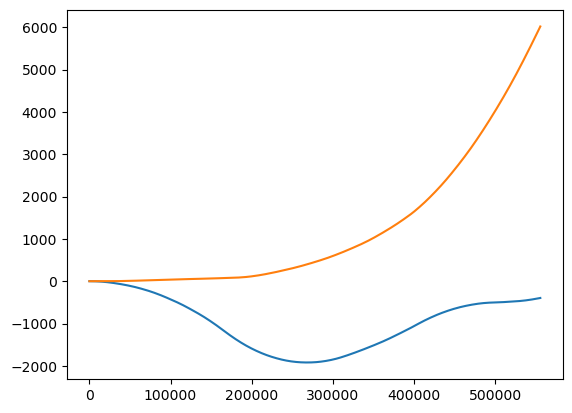

In [23]:
vh1 = np.cumsum((acc_R[0][1:] + acc_R[0][:-1])*1e-3*0.5,axis=0)
vh2 = np.cumsum((acc_R[1][1:] + acc_R[1][:-1])*1e-3*0.5,axis=0)
ph1 = np.cumsum((vh1[1:] + vh1[:-1])*1e-3*0.5,axis=0)
ph2 = np.cumsum((vh2[1:] + vh2[:-1])*1e-3*0.5,axis=0)
plt.plot(ph1)
plt.plot(ph2)

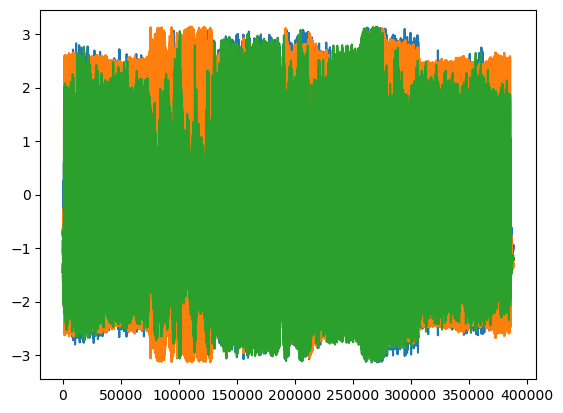

In [215]:
plt.plot(Rot.from_matrix(np.flip(R,[1,2])).as_rotvec())
plt.show()

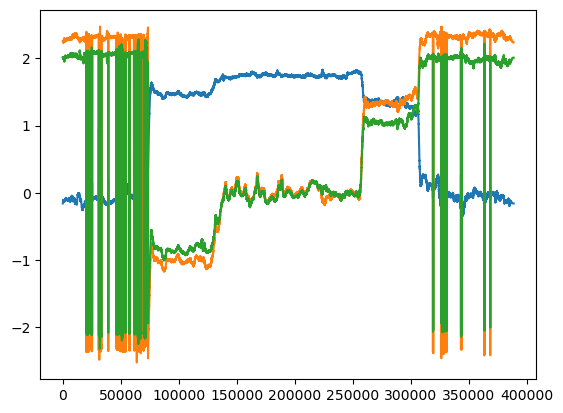

In [216]:
plt.plot(Rot.from_quat(grv.iloc[:,1:]).as_rotvec())
plt.show()

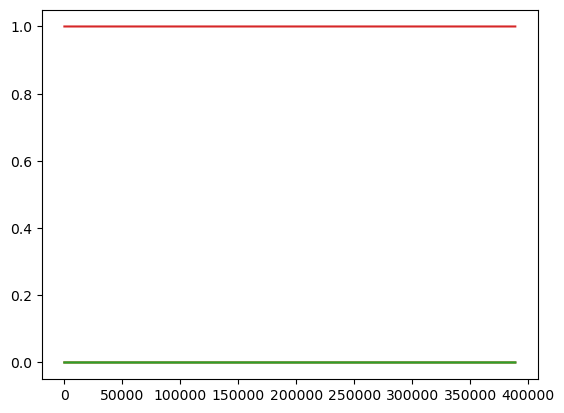

In [217]:
plt.plot(Rot.from_matrix(np.flip(I,[1,2])).as_quat())

### Debugging / loader

In [87]:
count = 0
for item in load_interface(filelist, 0):
    print(item)
    count += 1
    if count > 3:
        break

X_linacc         0.0
Y_linacc         0.0
Z_linacc         0.0
X_gyro           NaN
Y_gyro           NaN
Z_gyro           NaN
Latitude_gps     NaN
Longitude_gps    NaN
Sigma_gps        NaN
X_grv            NaN
Y_grv            NaN
Z_grv            NaN
W_grv            NaN
Name: 2898634366811, dtype: float64
X_linacc         0.014879
Y_linacc        -0.023267
Z_linacc         0.061945
X_gyro                NaN
Y_gyro                NaN
Z_gyro                NaN
Latitude_gps          NaN
Longitude_gps         NaN
Sigma_gps             NaN
X_grv                 NaN
Y_grv                 NaN
Z_grv                 NaN
W_grv                 NaN
Name: 2898639097279, dtype: float64
X_linacc         0.047462
Y_linacc        -0.054178
Z_linacc         0.131540
X_gyro                NaN
Y_gyro                NaN
Z_gyro                NaN
Latitude_gps          NaN
Longitude_gps         NaN
Sigma_gps             NaN
X_grv            0.000000
Y_grv            0.000000
Z_grv            0.000000
W_grv

## KalmanFilter Algorithm

In [32]:
class KalmanFilter:
    '''
    Use order:
        set A, Q, H, R (system model)
        set P (Initial noise covariance)
        (update A, Q)
        predict
        (update R)
        update
    '''
    def __init__(self):
        self.__shape = None # [n, m], a list of state vector length n and measurment vector length m.
        self.__A = None # State transition model. Ax[t-1] = x[t], shape [n, n]
        self.__Q = None # State transition noise covariance. Shape [n, n]
        self.__H = None # State to measurement model. Hx = z, shape [m, n]
        self.__R = None # Measurement noise covariance. Shape [m, m]
        self.__x = None # System state vector of shape [n,1]
        self.__z = None # System measurement vector of shape [m,1]
        self.__P = None # Estimate of noise covariance
        self.__K = None # Kalman gain
    # KF shape
    @property
    def shape(self):
        return self.__shape
    @shape.setter
    def shape(self,shape_new):
        if not isinstance(shape_new,tuple):
            raise TypeError('New shape should be a tuple!')
        if not len(shape_new) == 2:
            raise ValueError('New shape should have length of 2!')
        self.__shape = shape_new    
    
    # KF Parameters
    @property
    def A(self):
        if self.__A is None:
            raise Exception('A is not yet set!')
        return self.__A
    @A.setter
    def A(self, A_new):
        if self.__shape is None:
            raise Exception('Shape must be set first!')
        if not A_new.shape == (self.shape[0],self.shape[0]):
            raise ValueError('Shape of A should be ({},{})'.format(self.shape[0],self.shape[0]))
        self.__A = A_new
        return None
    @property
    def Q(self):
        if self.__Q is None:
            raise Exception('Q is not yet set!')
        return self.__Q
    @Q.setter
    def Q(self,Q_new):
        if self.__shape is None:
            raise Exception('Shape must be set first!')
        if not Q_new.shape == (self.shape[0],self.shape[0]):
            raise ValueError('Shape of Q should be ({},{})'.format(self.shape[0],self.shape[0]))
        self.__Q = Q_new
        return None
    @property
    def H(self):
        if self.__H is None:
            raise Exception('H is not yet set!')
        return self.__H
    @H.setter
    def H(self,H_new):
        if self.__shape is None:
            raise Exception('Shape must be set first!')
        if not H_new.shape == (self.shape[1],self.shape[0]):
            raise ValueError('Shape of H should be ({},{})'.format(self.shape[1],self.shape[0]))
        self.__H = H_new
        return None
    @property
    def R(self):
        if self.__R is None:
            raise Exception('R is not yet set!')
        return self.__R
    @R.setter
    def R(self,R_new):
        if self.__shape is None:
            raise Exception('Shape must be set first!')
        if not R_new.shape == (self.shape[1],self.shape[1]):
            raise ValueError('Shape of R should be ({},{})'.format(self.shape[1],self.shape[1]))
        self.__R = R_new
        return None
    
    # State vector getter and setter
    @property
    def x(self):
        if self.__x is None:
            raise Exception('x is not yet set!')
        return self.__x
    @x.setter
    def x(self, x_new):
        if self.__shape is None:
            raise Exception('Shape must be set first!')
        if (not x_new.shape == (self.shape[0])) and (not x_new.shape == (self.shape[0],1)):
            raise ValueError('Shape of x should be ({},1) or ({})'.format(self.shape[0],self.shape[0]))
        self.__x = x_new
        return None    
    
    # Measurement vector getter and setter
    @property
    def z(self):
        if self.__z is None:
            raise Exception('z is not yet set!')
        return self.__z
    @z.setter
    def x(self, z_new):
        if self.__shape is None:
            raise Exception('Shape must be set first!')
        if (not z_new.shape == (self.shape[1])) and (not z_new.shape == (self.shape[1],1)):
            raise ValueError('Shape of z should be ({},1) or ({})'.format(self.shape[1],self.shape[1]))
        self.__z = z_new
        return None
    
    # Check if all system models are assigned
    def chk_model(self):
        if self.A is None:
            raise Exception('Value of A is not assigned!')
        if self.Q is None:
            raise Exception('Value of Q is not assigned!')
        if self.H is None:
            raise Exception('Value of H is not assigned!')
        if self.R is None:
            raise Exception('Value of R is not assigned!')
    
    # Prediction step
    def predict(self):
        # self.chk_model()
        x_prev = self.__x
        self.__x = np.dot(self.A, x_prev) # x[t-1] -> ^x[t]
        self.__P = np.dot(np.dot(self.A,self.P),self.A.T) + self.Q
        return {'x_prev':x_prev,
                'x_pred':self.__x,
                'x_esti':None,
                'z':None,
                'K':None,
                'P':None}
    
    # Update (Estimation) step
    def update(self):
        # self.chk_model()
        x_pred = self.__x
        self.__K = np.dot(np.dot(self.__P,
                                 self.__H.T),
                          np.linalg.inv(np.dot(np.dot(self.__H,
                                                      self.__P),
                                               self.__H.T)+self.__R))
        self.__x = x_pred + np.dot(self.__K,
                                   self.__z - np.dot(self.__H,
                                                     x_pred)) # ^x[t] -> ^^x[t]
        self.__P = self.__P - np.dot(self.__K,
                                     np.dot(self.__H,
                                            self.__P))
        return {'x_prev':None,
                'x_pred':x_pred,
                'x_esti':self.__x,
                'z':self.__z,
                'K':self.__K,
                'P':self.__P}
    
KF = KalmanFilter # Define alias

In [33]:
# Class initial model assignment test
foo = KalmanFilter()
foo.shape = (4,2)
foo.A = np.eye(4)
foo.Q = np.zeros((4,4))
foo.H = np.eye(2,4)
foo.R = np.zeros((2,2))
foo.chk_model()

# Class initial model assignment test (KF: Alias of Kalman filter)
foo = KF()
foo.shape = (4,2)
foo.A = np.eye(4)
foo.Q = np.zeros((4,4))
foo.H = np.eye(2,4)
foo.R = np.zeros((2,2))
foo.chk_model()

In [34]:
# Class for INS structure
class GPSKalmanFilter(KalmanFilter):
    def __init__(self):
        super().__init__()
    @property
    
    # getter and setter for gps accuracy (1sigma)
    def gps_sigma(self):
        return np.sum(np.diag(self.R[-2:,-2])) + self.R[-1,-2] + self.R[-2,-1] # self.R[-1,-2] = self.R[-2,-1]
    @gps_sigma.setter # update R
    def gps_sigma(self,sigma):
        '''
        sigma : scalar value
        '''
        self.R[-2:,-2:] = (sigma**2) # Last two state variables are assumed to be positions. variance = sigma^2
    # More functions
    # Whatever
    
GPSKF = GPSKalmanFilter

In [35]:
# Class initial model assignment test (GPSKF: Alias of GPSKalman filter)
foo = GPSKF()
foo.shape = (4,2)
foo.A = np.eye(4)
foo.Q = np.zeros((4,4))
foo.H = np.eye(2,4)
foo.R = np.zeros((2,2))
foo.chk_model()

## INS

In [288]:
class InertialNavigationSystem:
    def __init__(self, idx:dict = {}):
        self.KF = GPSKF
        self.count = None
        self.idx = idx
        if (len(idx) > 0) and not all([key in idx.keys() for key in ['linacc','gyro','gps','grv']]):
            raise ValueError('idx should have all of linacc, gyro, gps and grv as key!')
        elif any([not isinstance(val, slice) for val in idx.values()]):
            raise ValueError('idx should have only slices as value!')
    def __call__(self, loader):
        self.count = 0
        return self.run(loader)
        
    def identify(self, sample):
        state = {'linacc':True, 'gyro':True, 'gps':True, 'grv':True}
        for sensor in list(pd.Series(sample[sample.isna()].index).str.rsplit(pat = '_',expand = True).loc[:,1].unique()):
            state[sensor] = False
        return state
        
    # Perform inertial position estimation
    def run(self, loader):
        self.yaw_model = self.build_yaw()
        self.pos_model = self.build_pos()
        linacc_history = []
        values = []
        for sample in loader:
            print(sample)
            time_in = sample.name
            flag = self.identify(sample)
            if self.count == 0:
                latest_value = flag.copy()
                latest_value = dict.fromkeys(latest_value.keys(),None)
            for key in flag:
                if flag[key]:
                    latest_value[key] = np.array(sample.iloc[self.idx[key]])
            if latest_value['grv'] is None:
                pass
            else:
                if flag['linacc']:
                    linacc_current = Rot.from_quat(latest_value['grv']).apply(latest_value['linacc'])
                    linacc_history.append(linacc_current)
            values.append(latest_value['linacc'])
            self.count += 1
            if self.count > 1000:
                break
            # print(latest_value)
            # print(flag)
        return values
    def build_yaw(self, dt = 1e-3, **kwargs):
        '''
        Kalman filter for yaw estimation
        '''
        model = self.KF()
        model.shape = (3,2)
        model.A = np.array([[1,0,0],[dt,1,-1],[0,0,1]]).reshape(3,3)
        return model
    def build_pos(self, dt = 1e-3, **kwargs):
        '''
        Kalman filter for position estimation
        '''
        model = self.KF()
        model.shape = (4,2)
        model.A = np.array([[1,0,0,0],[0,1,0,0],[dt,0,1,0],[0,dt,0,1]]).reshape(4,4)
        return model
    # 
    # 입력 데이터 샘플링 레이트
    # 입력 데이터 필터 적용 (1차 재귀 로우패스)
    # 시스템 모델 변경
    
INS = InertialNavigationSystem # Define alias

In [289]:
foo = INS({'linacc':slice(0,3),'gyro':slice(3,6),'gps':slice(6,9),'grv':slice(9,13)})

In [290]:
bar = foo(load_interface(filelist, 1))

X_linacc         0.155872
Y_linacc        -0.061578
Z_linacc         0.019354
X_gyro                NaN
Y_gyro                NaN
Z_gyro                NaN
Latitude_gps          NaN
Longitude_gps         NaN
Sigma_gps             NaN
X_grv                 NaN
Y_grv                 NaN
Z_grv                 NaN
W_grv                 NaN
Name: 868880632438129, dtype: float64
X_linacc         0.010104
Y_linacc         0.072053
Z_linacc        -0.070537
X_gyro                NaN
Y_gyro                NaN
Z_gyro                NaN
Latitude_gps          NaN
Longitude_gps         NaN
Sigma_gps             NaN
X_grv            0.116055
Y_grv            0.044592
Z_grv            0.705617
W_grv            0.697601
Name: 868880637252661, dtype: float64
X_linacc        -0.123565
Y_linacc         0.064474
Z_linacc        -0.115759
X_gyro                NaN
Y_gyro                NaN
Z_gyro                NaN
Latitude_gps          NaN
Longitude_gps         NaN
Sigma_gps             NaN
X_grv         

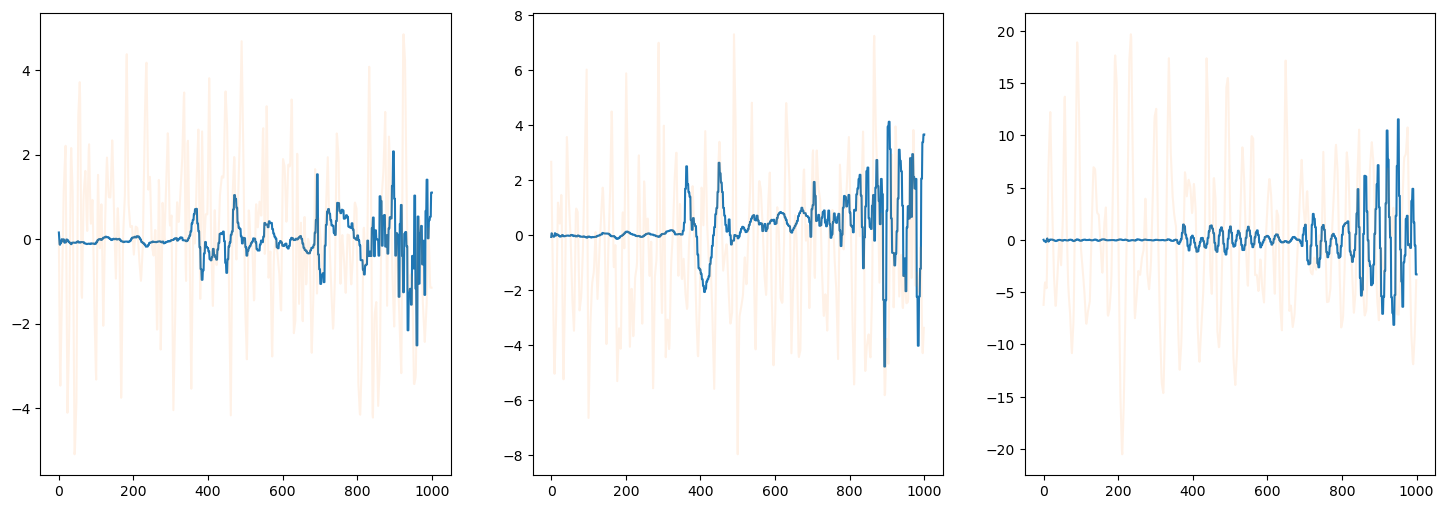

In [286]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
for i in range(3):
    ax[i].plot(np.array(bar)[:,i])
    ax[i].plot(np.array(linacc)[:1000,i+1],alpha=0.1)

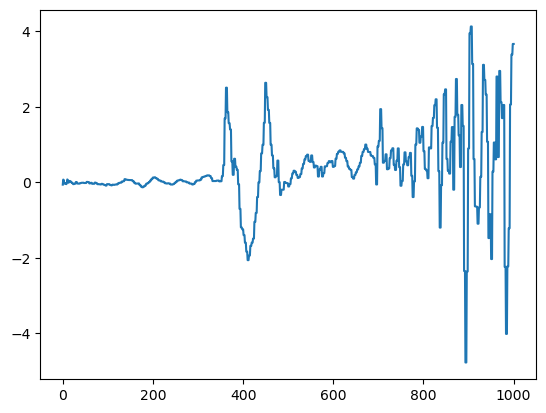

In [270]:
plt.plot(np.array(bar)[:,1])

In [222]:
bar = TrialData(filelist.get_dirlist(1), sensorlist = ['acc','linacc','gyro','gps','game_rv'], dt = int(1e6))

In [236]:
linacc = bar.interpolated['LINEAR_ACCELERATION']
grv = bar.interpolated['GAME_ROTATION_VECTOR']

In [237]:
linacc

,Time,X,Y,Z
0,8.688835e+14,-0.048989,2.670606,-6.209950
1,8.688835e+14,-1.054927,1.776472,-5.597532
2,8.688835e+14,-2.060865,0.882338,-4.985114
3,8.688835e+14,-3.066803,-0.011796,-4.372697
4,8.688835e+14,-3.468826,-0.944671,-4.057933
...,...,...,...,...
555555,8.694391e+14,-0.027244,-0.176455,0.562091
555556,8.694391e+14,0.015425,-0.138964,0.539537
555557,8.694391e+14,0.068017,-0.089931,0.491180
555558,8.694391e+14,0.120608,-0.040898,0.442823


In [238]:
grv

,Time,X,Y,Z,W
0,8.688835e+14,0.099855,0.088166,0.744191,0.654549
1,8.688835e+14,0.100257,0.088064,0.744060,0.654650
2,8.688835e+14,0.100659,0.087962,0.743930,0.654750
3,8.688835e+14,0.101061,0.087859,0.743799,0.654851
4,8.688835e+14,0.101513,0.087706,0.743670,0.654949
...,...,...,...,...,...
555555,8.694391e+14,0.040497,-0.054635,-0.697470,0.713379
555556,8.694391e+14,0.040448,-0.054651,-0.697471,0.713380
555557,8.694391e+14,0.040404,-0.054666,-0.697471,0.713381
555558,8.694391e+14,0.040360,-0.054680,-0.697472,0.713382


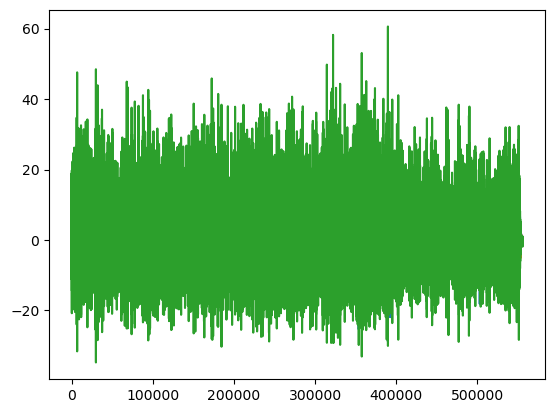

In [240]:
plt.plot(Rot.from_quat(grv.iloc[:,1:]).apply(linacc.iloc[:,1:]))

### Covariance Analysis

In [16]:
def varanalysis(*args, **kwargs):
    nbins = 100
    argsx = args
    argsy = args
    kwargsx = dict()
    kwargsy = dict()
    for key in kwargs:
        if isinstance(kwargs[key],list):
            kwargsx[key] = kwargs[key][0]
            kwargsy[key] = kwargs[key][1]
        else:
            kwargsx[key] = kwargs[key]
            kwargsy[key] = kwargs[key]
    foo_x = np.random.normal(*argsx,**kwargsx)
    foo_y = np.random.normal(*argsy,**kwargsy)

    fig = plt.figure(figsize = (16,12))
    spec = fig.add_gridspec(ncols=3, nrows=3)
    ax00 = fig.add_subplot(spec[0,0:2])
    ax10 = fig.add_subplot(spec[1,0:2])
    ax20 = fig.add_subplot(spec[2,0:2])
    
    ax00.hist(foo_x,bins=nbins)
    ax00.set_xlim([-5*kwargsx['scale'],5*kwargsx['scale']])
    ax00.set_title('$x_1$ distribution, count, $\sigma_1$ = {}, $\hat\sigma_1$ = {}'.format(kwargsx['scale'], np.round(np.std(foo_x),5)))
    ax10.hist(foo_y,bins=nbins)
    ax10.set_xlim([-5*kwargsy['scale'],5*kwargsy['scale']])
    ax10.set_title('$x_2$ distribution, count, $\sigma_2$ = {}, $\hat\sigma_2$ = {}'.format(kwargsy['scale'], np.round(np.std(foo_y),5)))
    d = np.linalg.norm(np.stack([foo_x, foo_y], axis=1),axis=1)
    ax20.hist(d, bins = nbins)
    ax20.set_title('$d$ distribution, count, $\hat\sigma_d$ = {}'.format(np.round(np.std(d),5)))
    
    ax01 = fig.add_subplot(spec[0,2])
    ax01.boxplot(foo_x,notch=True,meanline=True)
    ax01.set_title('x1 dist, quantile')
    ax01.set_xticks([1])
    ax01.set_xticklabels(['$x_1$'])
    ax11 = fig.add_subplot(spec[1,2])
    ax11.boxplot(foo_y,notch=True,meanline=True)
    ax11.set_title('x2 dist, quantile')
    ax11.set_xticks([1])
    ax11.set_xticklabels(['$x_2$'])
    ax21 = fig.add_subplot(spec[2,2])
    plt.close()
    return fig

In [289]:
def varanalysis(*args, **kwargs):
    nbins = 100
    foo_pi = np.random.uniform(low=-np.pi, high=np.pi, size = kwargs['size'])
    foo_r = abs(np.random.normal(*args,**kwargs))
    foo_x = np.multiply(foo_r,np.cos(foo_pi))
    foo_y = np.multiply(foo_r,np.sin(foo_pi))
    
    fig = plt.figure(figsize = (16,12))
    spec = fig.add_gridspec(ncols=3, nrows=3)
    ax00 = fig.add_subplot(spec[0,0:2])
    ax10 = fig.add_subplot(spec[1,0:2])
    ax20 = fig.add_subplot(spec[2,0:2])
    
    ax00.hist(foo_x,bins=nbins)
    ax00.set_xlim([-5*np.std(foo_x),5*np.std(foo_x)])
    ax00.set_title('$x_1$ distribution, count, $\sigma$ = {}, $\hat\sigma_1$ = {}'.format(kwargs['scale'], np.round(np.std(foo_x),5)))
    ax10.hist(foo_y,bins=nbins)
    ax10.set_xlim([-5*np.std(foo_y),5*np.std(foo_y)])
    ax10.set_title('$x_2$ distribution, count, $\sigma$ = {}, $\hat\sigma_2$ = {}'.format(kwargs['scale'], np.round(np.std(foo_y),5)))
    d = np.linalg.norm(np.stack([foo_pi, foo_r], axis=1),axis=1)
    print(np.mean(d-foo_r))
    ax20.hist(d, bins = nbins)
    ax20.set_title('$d$ distribution, count, $\hat\sigma_d$ = {}'.format(np.round(np.std(d),5)))
    
    ax01 = fig.add_subplot(spec[0,2])
    ax01.boxplot(foo_x,notch=True,meanline=True)
    ax01.set_title('x1 dist, quantile')
    ax01.set_xticks([1])
    ax01.set_xticklabels(['$x_1$'])
    ax11 = fig.add_subplot(spec[1,2])
    ax11.boxplot(foo_y,notch=True,meanline=True)
    ax11.set_title('x2 dist, quantile')
    ax11.set_xticks([1])
    ax11.set_xticklabels(['$x_2$'])
    ax21 = fig.add_subplot(spec[2,2])
    ax21.scatter(foo_x, foo_y, s= .1, alpha = .1)
    sigma1 = plt.Circle((0,0),np.mean(d) + np.std(d),ec = 'r', fc = None, fill = False)
    sigma1_ = plt.Circle((0,0),np.mean(d) - np.std(d),ec = 'r', fc = None, fill = False)
    sigma2 = plt.Circle((0,0),np.mean(d) +2*np.std(d),ec = 'k', fc = None, fill = False)
    sigma2_ = plt.Circle((0,0),np.mean(d) -2*np.std(d),ec = 'k', fc = None, fill = False)
    sigma3_ = plt.Circle((0,0),np.mean(d) +3*np.std(d),ec = 'g', fc = None, fill = False)
    sigma3 = plt.Circle((0,0),np.mean(d) -3*np.std(d),ec = 'g', fc = None, fill = False)
    ax21.add_patch(sigma1)
    ax21.add_patch(sigma2)
    ax21.add_patch(sigma3)
    ax21.add_patch(sigma1_)
    ax21.add_patch(sigma2_)
    ax21.add_patch(sigma3_)
    plt.close()
    print(sum((d<np.mean(d)+np.std(d))&(d>np.mean(d)-np.std(d)))/len(d),
          sum((d<np.mean(d)+2*np.std(d))&(d>np.mean(d)-2*np.std(d)))/len(d),
          sum((d<np.mean(d)+3*np.std(d))&(d>np.mean(d)-3*np.std(d)))/len(d))
    return fig

0.16352841858662343
0.682826 0.954384 0.997293


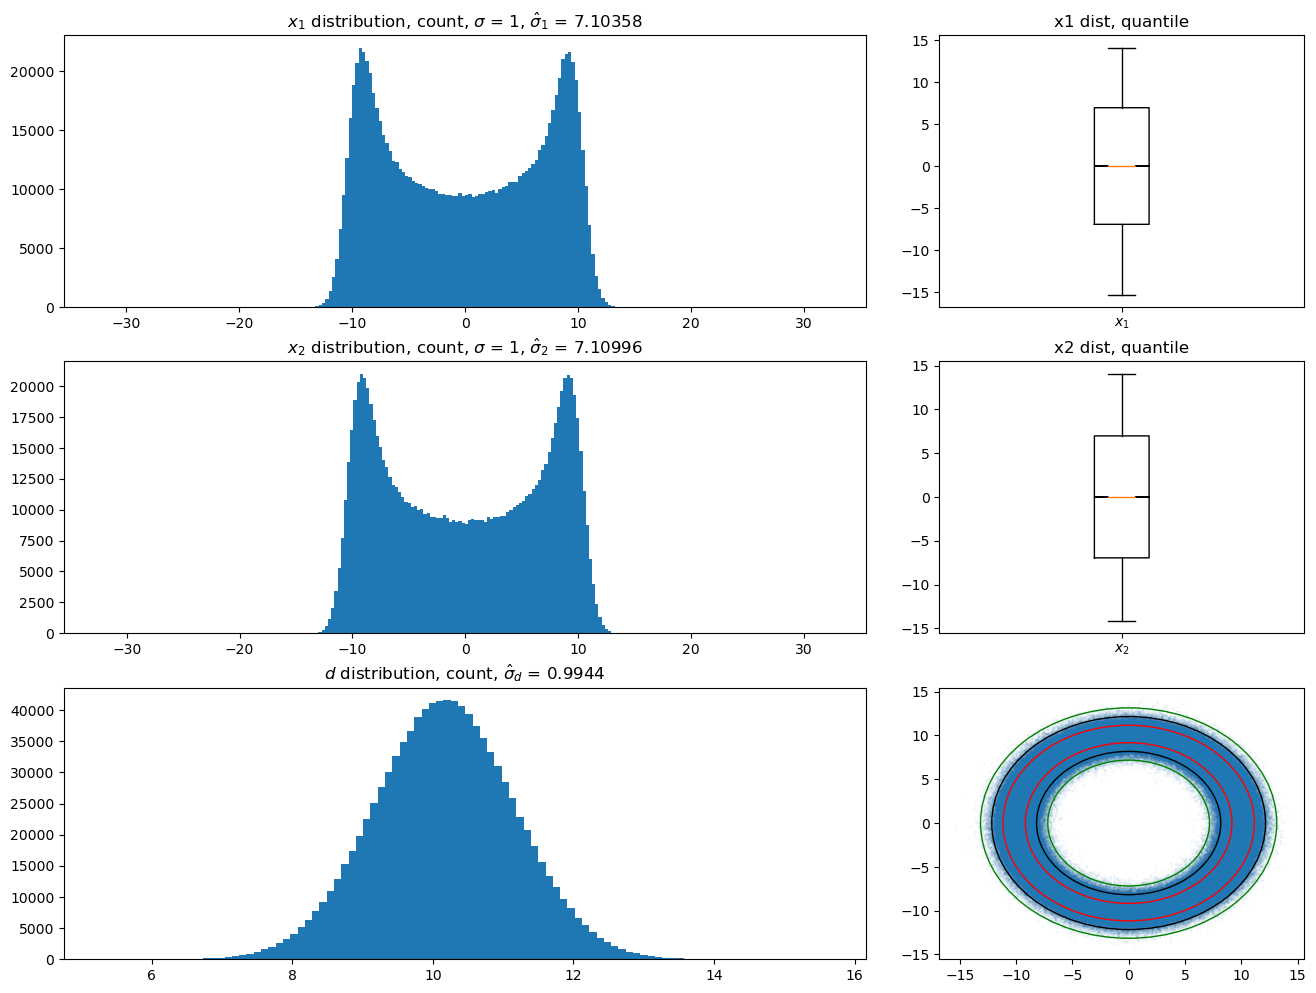

In [290]:
varanalysis(loc=10,scale=1,size=1000000)

In [285]:
class foo:
    def __init__(self):
        pass
    @dispatch(int,int)
    def __call__(self, x, y):
        return x + y
    @dispatch(float,float)
    def __call__(self, x, y):
        return x - y
    @dispatch(object,object)
    def __call__(self, x, y):
        return y - x

In [286]:
foo()(1.,2)

1.0

In [284]:
type(foo().__call__)

multipledispatch.dispatcher.MethodDispatcher